In [1]:
import re
import os
import sys
import cairosvg
import numpy as np
from pypdf import PdfWriter
from mindquantum.core.gates import *
from IPython.display import display_svg
from mindquantum.core.circuit import Circuit
from mindquantum.core import ParameterResolver

sys.path.append('../..')
np.set_printoptions(linewidth=1000)
from utils import qutrit_symmetric_ansatz


def draw_svg(ansatz: Circuit, name: str, ext: str = 'pdf', dpi: int = 400, scale: int = 8):
    path = os.path.join(os.getcwd(), f'{name}_svg')
    svg = f'{path}.svg'
    circ = Circuit()
    count = 0
    for gate in ansatz:
        if 'X' not in gate.name and len(gate.coeff.params_name) == 1:
            count += 1
            gate.coeff = ParameterResolver(f'θ{count}')
        circ += gate
    circ_svg = circ.svg()
    circ_svg.to_file(svg)
    display_svg(circ_svg)
    if 'png' in ext:
        cairosvg.svg2png(url=svg, write_to=f'{path}.png', dpi=dpi, scale=scale)
    elif 'pdf' in ext:
        cairosvg.svg2pdf(url=svg, write_to=f'{path}.pdf', dpi=dpi, scale=scale)
    else:
        raise ValueError(f'Wrong input extension: {ext}')
    if os.path.exists(svg):
        os.remove(svg)


def draw_pdf(ansatz: Circuit, name: str, prefix: str, suffix: str):
    name = f'{name}_qpic.qpic'
    with open(name, 'w') as f:
        f.write(prefix)
        ind = 0
        for gate in ansatz:
            line, count = draw_qpic(gate, ind)
            ind = count
            f.write(f'{line}\n')
        f.write(suffix)
    os.system(f'python qpic {name} -f pdf')


def draw_qpic(gate: BasicGate, ind: int):
    line = f'The line did not change {str(gate)}'
    name = gate.name
    obj = gate.obj_qubits
    ctrl = gate.ctrl_qubits
    pi2 = r'\frac{\pi}{2}'
    g = {'RY': ['R_y', 28, 32, 36], 'RZ': ['R_z', 28, 32, 36], \
         'GP': ['GP', 32, 36, 40], 'PS': ['PS', 32, 36, 40]}
    if len(ctrl) > 0:
        ctrl_str = ' '.join([f'q{c}' for c in ctrl])
        if 'X' == name:
            line = f'+q{obj[0]} {ctrl_str}'
        else:
            if len(gate.coeff.params_name) == 1:
                ind += 1
                if ind < 10:
                    line = f'q{obj[0]} G ${g[name][0]}(\\theta_{{{ind}}})$ {ctrl_str} width={g[name][1]}'
                elif ind >= 10 and ind < 100:
                    line = f'q{obj[0]} G ${g[name][0]}(\\theta_{{{ind}}})$ {ctrl_str} width={g[name][2]}'
                else:
                    line = f'q{obj[0]} G ${g[name][0]}(\\theta_{{{ind}}})$ {ctrl_str} width={g[name][3]}'
            elif len(gate.coeff.params_name) == 0 and 'RY' == name:
                if gate.coeff.const < 0:
                    line = f'q{obj[0]} G $R_y(-{pi2})$ {ctrl_str} width=35'
                else:
                    line = f'q{obj[0]} G $R_y({pi2})$ {ctrl_str} width=28'
            else:
                raise ValueError(f'Some thing go wrong {gate} para name {gate.coeff.params_name}')
            line += ' style={rounded corners=1pt}'
    else:
        if 'X' == name:
            line = f'q{obj[0]} G $X$'
        elif 'RY' == name:
            if len(gate.coeff.params_name) == 1:
                ind += 1
                if ind < 10:
                    line = f'q{obj[0]} G $R_y(\\theta_{{{ind}}})$ width=28'
                elif ind >= 10 and ind < 100:
                    line = f'q{obj[0]} G $R_y(\\theta_{{{ind}}})$ width=32'
                else:
                    line = f'q{obj[0]} G $R_y(\\theta_{{{ind}}})$ width=36'
            elif len(gate.coeff.params_name) == 0:
                if gate.coeff.const < 0:
                    line = f'q{obj[0]} G $R_y(-{pi2})$ width=35'
                else:
                    line = f'q{obj[0]} G $R_y({pi2})$ width=28'
            else:
                raise ValueError(f'Some thing go wrong {gate} para name {gate.coeff.params_name}')
        else:
            raise ValueError(f'The single qubit gate {gate} is not in [X, RY]')
        line += ' style={rounded corners=1pt}'
    return line, ind

c:\Program Files\Python39\lib\site-packages\mindquantum\simulator\__init__.py:17: UserWarning: Unable import mqvector gpu backend due to: cannot import name '_mq_vector_gpu' from partially initialized module 'mindquantum' (most likely due to a circular import) (c:\Program Files\Python39\lib\site-packages\mindquantum\__init__.py)
  from .available_simulator import SUPPORTED_SIMULATOR
c:\Program Files\Python39\lib\site-packages\mindquantum\__init__.py:57: UserWarning: MindSpore not installed, you may not be able to use hybrid quantum classical neural network.
  from . import (


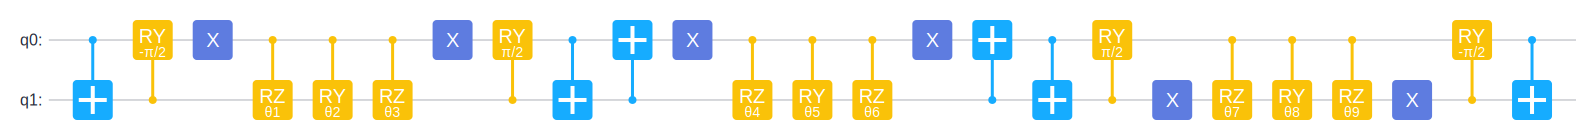

In [2]:
prefix = r'''GATESIZE 14
DEPTHPAD 2
WIREPAD 6
q0 W
q1 W
q0 LABEL width=0
q0 q1 G $U_\mathrm{enc}(\boldsymbol{\theta})$ width=32
q0 LABEL width=0
=
'''
suffix = 'q0 LABEL width=0'
nq = 2
mat = np.eye(2**nq)
obj = range(nq)[::-1]
gate = UnivMathGate('U', mat).on(obj)
ansatz = qutrit_symmetric_ansatz(gate)
draw_pdf(ansatz, 'single_qutrit', prefix, suffix)
draw_svg(ansatz, 'single_qutrit')

In [6]:
prefix = '''GATESIZE 14
DEPTHPAD 2
WIREPAD 6
q0 W {>>} {>>}
q1 W {>>} {>>}
q2 W {>>} {>>}
q3 W {>>} {>>}
'''
suffix = '''q0 LABEL width=0
q1 LABEL width=0
q2 LABEL width=0
q3 LABEL width=0'''
first = r'''GATESIZE 14
DEPTHPAD 2
WIREPAD 6
q0 W {} {>>}
q1 W {} {>>}
q2 W {} {>>}
q3 W {} {>>}
q0 LABEL width=0
q0 q1 q2 q3 G $\large U_\mathrm{enc}(\boldsymbol{\theta})$ width=40 style={rounded corners=1pt}
q0 LABEL width=0
=
'''
end = r'''GATESIZE 14
DEPTHPAD 2
WIREPAD 6
q0 W {>>}
q1 W {>>}
q2 W {>>}
q3 W {>>}
'''

nq = 4
mat = np.eye(2**nq)
obj = range(nq)[::-1]
gate = UnivMathGate('', mat).on(obj)
ansatz = qutrit_symmetric_ansatz(gate)

num_gate = [19, 26, 20, 23, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 21]
ind_tuple = [(sum(num_gate[:i]), sum(num_gate[:i + 1])) for i, j in enumerate(num_gate)]
print(sum(num_gate))


def draw_pdf(ansatz: Circuit, name: str, prefix_: str, suffix: str):
    ind = 0
    for i, j in enumerate(ind_tuple):
        qpic = f'{name}_{j[0]}_{j[1]}.qpic'
        print(i + 1, j)
        if i == 0:
            prefix = f'{first}\n{suffix}\n'
        elif i == len(num_gate) - 1:
            prefix = f'{end}\n{suffix}\n'
        else:
            prefix = f'{prefix_}\n{suffix}\n'
        with open(qpic, 'w') as f:
            f.write(prefix)
            for gate in ansatz[j[0]:j[1]]:
                line, count = draw_qpic(gate, ind)
                ind = count
                f.write(f'{line}\n')
            f.write(suffix)
        os.system(f'python qpic {qpic} -f pdf')


def merge_pdf(name: str, remove: bool = True):
    pdf = f'{name}_\d+_\d+.pdf'
    key = lambda x: [int(s) if s.isdigit() else s for s in re.split('(\d+)', x)]
    dir_sort = sorted(os.listdir(os.getcwd()), key=key)
    pdf_list = [f for f in dir_sort if re.search(pdf, f)]
    merger = PdfWriter()
    for f in pdf_list:
        merger.append(f)
    merger.write(f'{name}_qpic.pdf')
    merger.close()
    if remove:
        for f in pdf_list:
            os.remove(f)
            os.remove(f.replace('pdf', 'qpic'))


draw_pdf(ansatz, 'two_qutrit', prefix, suffix)
merge_pdf('two_qutrit', True)
# draw_svg(ansatz, 'two_qutrit')

352
1 (0, 19)
2 (19, 45)
3 (45, 65)
4 (65, 88)
5 (88, 110)
6 (110, 132)
7 (132, 154)
8 (154, 176)
9 (176, 198)
10 (198, 220)
11 (220, 242)
12 (242, 264)
13 (264, 286)
14 (286, 308)
15 (308, 331)
16 (331, 352)
